# Biblioteki

In [1]:
import numpy as np
import pandas as pd
import pmdarima as pm

import numpy as np
import pandas as pd
import json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = [15, 10]
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

print('numpy version: %r' % np.__version__)
print('pmdarima version: %r' % pm.__version__)

numpy version: '1.15.4'
pmdarima version: '1.1.0'


# Wczytanie zbiorów

In [2]:
train = pd.read_csv('datasets/podzielone/ekonometryczne/train_ekon.csv', index_col=0)
val1 = pd.read_csv('datasets/podzielone/ekonometryczne/valid1_ekon.csv', index_col=0)
val2 = pd.read_csv('datasets/podzielone/ekonometryczne/valid2_ekon.csv', index_col=0)
val3 = pd.read_csv('datasets/podzielone/ekonometryczne/valid3_ekon.csv', index_col=0)
test = pd.read_csv('datasets/podzielone/ekonometryczne/test_ekon.csv', index_col=0)

train.index = pd.to_datetime(train.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
val3.index = pd.to_datetime(val3.index)
test.index = pd.to_datetime(test.index)

whole = pd.concat([train, val1, val2, val3, test])
valid = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')

train1 = train.asfreq('B', method='bfill')
train2 = pd.concat([train, val1]).asfreq('B', method='bfill')
train3 = pd.concat([train, val1, val2]).asfreq('B', method='bfill')

val1 = val1.asfreq('B', method='bfill')
val2 = val2.asfreq('B', method='bfill')
val3 = val3.asfreq('B', method='bfill')
test = test.asfreq('B', method='bfill')

In [3]:
display(train.head(3))
display(val1.head(3))
display(val2.head(3))
display(val3.head(3))
display(test.head(3))
display(whole.head(3))

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

# Wybór modelu

In [4]:
# Fit a simple auto_arima model
modl = pm.auto_arima(train1['return ratio'], error_action='ignore', trace=True, seasonal=True, max_p=5, max_q=5)
modl.summary()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-6880.923, BIC=-6849.314, Fit time=2.472 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-5893.405, BIC=-5882.868, Fit time=0.174 seconds


/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-6319.021, BIC=-6303.216, Fit time=0.327 seconds


/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-6884.295, BIC=-6868.490, Fit time=0.935 seconds


/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-6882.558, BIC=-6861.485, Fit time=2.236 seconds


/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-6882.888, BIC=-6861.815, Fit time=2.039 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-6883.146, BIC=-6856.804, Fit time=1.829 seconds
Total fit time: 10.071 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1435
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3445.147
Date:                Sun, 24 Mar 2019   AIC                          -6884.295
Time:                        21:58:26   BIC                          -6868.490
Sample:                             0   HQIC                         -6878.394
                               - 1435                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.551e-07   5.76e-06     -0.114      0.910    -1.2e-05    1.06e-05
ma.L1         -0.9938      0.005   -200.685      0.000      -1.004      -0.984
sigma2         0.0005   5.24e-06     91.587      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.68   Jarque-Bera (JB):             52518.67
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                             2.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Estymacja na teście

In [5]:
y_test = valid['return ratio']


/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to 

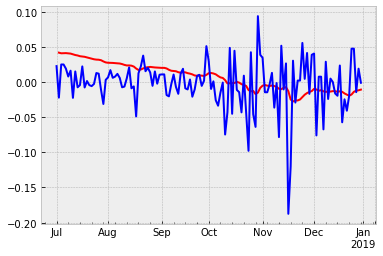

In [6]:
forecasts = []
order = (0,1,1)
seasonal_order = (0,0,0,0)
for i in range(len(y_test)):
    y_train = pd.concat([train['return ratio'], valid['return ratio'], y_test[:i+1]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, freq='B')
    results = model.fit()
    forecasts.append(results.forecast()[0])
forecasts = pd.Series(forecasts, index=y_test.index)
forecasts1 = forecasts + forecasts.shift()
forecasts1.plot(color='red', label='Forecast')
y_test.plot(color='blue', label='Real')
plt.show()

In [7]:
rmse(forecasts1[1:], y_test[1:])

0.03890830341063847